# Python Redition of Exact Solution

## Exact Solution 
The temperature evolution is provided by Strickland's code, available at:
link: http://personal.kent.edu/~mstrick6/code/index.html
Specifically, the RTA-CUDA v1.0

This is fed into the exact solution of the Boltzmann equation (BE) in the relaxation approximation 
$$
p_\mu \partial^\mu f(x,p)
=
C[f(x,p)]
=
-\frac{u\cdot p}{\tau_\mathrm{rel}}(f-f_\mathrm{eq})
$$
where $\tau_\mathrm{rel}$ is the relaxation time which can be function of spacetime, $f$ is the BE solution and $f_\mathrm{eq}$ is the equilibrium soulition given by
$$
f_\mathrm{eq} 
= 
\frac{g}{(2\pi)^3}
\exp\left\lbrack -\frac{u\cdot p}{T} \right\rbrack
$$
where $g$ is the degeneracy factor.

In the idealize case of Bjorken expansion, the symmetries reduce the space time dependence to just the proper time $\tau$. The most convenient momentum variables are the transverse momentum $p_T$ and the longitudinal momentum $w$. In this coordinate system, the exact solution to the BE is given by
$$
f(\tau,w,p_T)
=
D(\tau,\tau_0) f_0(w,p_T)
+
\int_{\tau_0}^\tau 
\frac{d\tau'}{\tau_\mathrm{rm}(\tau')}
D(\tau, \tau')
f_\mathrm{eq}(\tau',w,p_T),
$$
where $f_0$ is the inital distribution parameterized in the Romataschke-Strickland form
$$
f_0(w,p_T) 
=
\frac{g}{(2\pi)^3} \exp\left\lbrack 
- \frac{\sqrt{(1+\xi_0)w^2 + p_T^2 \tau_0^2}}{\Lambda \tau} \right\rbrack
$$
and $D$ is the damping function given by
$$
D(\tau_1, \tau_2) 
=
\exp\left\lbrack 
-\int_{\tau_1}^{\tau_2} \frac{d\tau''}{\tau_\mathrm{rel}(\tau'')} \right\rbrack.
$$
The $\tau_0$ is the initial time, the factor $\xi(\tau)$ quantifies the momentum anisotropy in the longitudinal versus transverse directions and $\xi_0 = \xi(\tau_0)$, and $\Lambda$ is the effective temperature which can calculated using 
$$
\Lambda(\tau) 
= 
2^{1/4}T
\left\lbrack 
\frac{1}{1+\xi(\tau)}
+
\frac{\arctan\sqrt{\xi(\tau)}}{\sqrt{\xi(\tau)}}
\right \rbrack^{-1/4}
$$

Lastly, the relaxation time can be written as 
$$
\tau_\mathrm{rel}(\tau) = \frac{5 \eta}{s T(\tau)}
$$ 
where $\eta$ is the shear viscosity and and $s$ is the entropy density. The ration $\eta/s$ is assumed to be constant.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
import seaborn as sns
import dill
import time

sns.set()
%matplotlib inline
plt.style.use('ggplot')

#global constants
hbarc = 0.1973   # GeV fm
etas  = 1.0/4.0/np.pi
xi0   = 0.0 
g     = 2.0
norm  = g / (2.0 * np.pi)**3

In [ ]:
def plot_generator(rows, columns, data_pairs, axis_title_pairs):
    ax = None 
    if rows == 1 and columns == 1

Initial time: 1.0 fm/s
Inital temperature: 0.6 GeV
Initial energy density: 10.2583 GeV/fm^3


Text(0, 0.5, 'e [GeV/fm$^3$]')

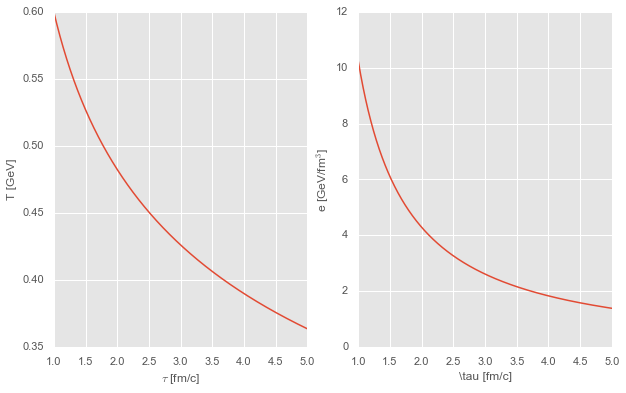

In [87]:
# Import data 
T_profile = pd.read_csv('input/beta_vs_tau_200.dat', sep=' ', header=None, names=['count','tau','temp'])

# important parameters from data and output
tau0 = T_profile['tau'][0]
T0   = T_profile['temp'][0]
print(f"Initial time: {tau0} fm/s")
print(f"Inital temperature: {T0} GeV")

# calculate energy evolution and set inital value
T_profile['e'] = 3.0 * g * T_profile['temp']**4. / np.pi**2 / hbarc**3.
e0 = T_profile['e'][0]
print(f"Initial energy density: {e0:.4f} GeV/fm^3")

# plot temperature and energy evolution evolution 
fix, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].plot(T_profile['tau'], T_profile['temp'])
axes[0].set_xlabel(r'$\tau$ [fm/c]')
axes[0].set_ylabel(r'T [GeV]')
axes[1].plot(T_profile['tau'], T_profile['e'])
axes[1].set_xlabel(r'\tau [fm/c]')
axes[1].set_ylabel(r'e [GeV/fm$^3$]')

Text(0, 0.5, 'f(\\tau,2.0,2.0)')

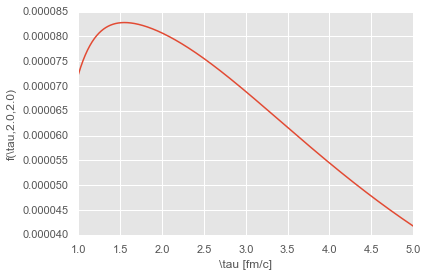

In [88]:
T_interp = InterpolatedUnivariateSpline(T_profile['tau'], T_profile['temp'], k=3)

def feq(tau, w, pT):
    T = T_interp(tau)
    v = np.sqrt((w / tau)**2 + pT**2.) 
    return norm * np.exp(-v / T ) 

def Damp(tau2, tau1):
    res = T_interp.integral(tau1, tau2) / 5.0 / etas
    return np.exp(-res)

def soln_integrand(taup, tau, w, pT):
    return Damp(tau, taup) * T_interp(taup) * feq(taup, w, pT) / 5.0 / etas

def R(z):
    if (z == 0.0):
        return 1.0
    else:
        result = 1.0 / (1.0 + z) + atan(sqrt(z)) / sqrt(z)
        return result * 0.5

def SPD(tau, w, pT):
    vp = np.sqrt((1. + xi0) * (w / tau)**2 + pT**2)
    L = T_interp(tau) / R(xi0)**.25
    res1 = Damp(tau, tau0) * norm * np.exp(- vp / L)
    res2, err = quad(soln_integrand, tau0, tau, args=(tau, w, pT))
    return res1 + res2

steps = len(T_profile['tau'])
spd = np.zeros(steps)
for i in range(steps):
    tau = T_profile['tau'][i]
    spd[i] = SPD(tau, 2.0, 2.0)
fig, ax = plt.subplots()
ax.plot(T_profile['tau'], spd)
ax.set_xlabel(r'\tau [fm/c]')
ax.set_ylabel(r'f(\tau,2.0,2.0)')

In [59]:
class Bjorken_RTA:
    """
    Class that calculates Bjorken-RTA exact solution and 
    computes arbitrary moments of the resulting solution
    """
    def __init__(self, file_path):
        """
        Loads data, calculates energy density profile and
        sets inital values for tau, temprature and energy
        denisty
        """
        # Temperature profile from Strickland code
        self.T_profile = pd.read_csv('input/beta_vs_tau_200.dat', sep='\t', header=None, names=['tau','temp'])
        self.tau0 = T_profile['tau'][0]
        self.T0   = T_profile['temp'][0]
        print(f"Initial time: {tau0} fm/s")
        print(f"Inital temperature: {T0} GeV")
        
        # Energy evolution from temperature evolution
        T_profile['e'] = 3.0 * g * T_profile['temp']**4. / np.pi**2. / hbarc**3.
        self.e0 = T_profile['e'][0]
        print(f"Initial energy density: {e0:.4f} GeV/fm^3")
        
        # Number of points in 
        self.steps = len(T_profile['tau'])
        
        

In [60]:
my_soln = Bjorken_RTA('input/T_500.dat')

Initial time: 1.0 fm/s
Inital temperature: 0.6 GeV
Initial energy density: 10.2583 GeV/fm^3


In [75]:
print( T_profile['tau'][1] )
print( T_interp.integral(1.,3.) )

1.012753378911642
0.9791534394343426


In [79]:
SPD(1.2, 2.0, 2.0)

7.977727354888822e-05